# Data shape

## Dummy data

In [2]:
import pandas as pd
label = pd.DataFrame(data={'file':
                           ["bf-01", "bf-01", "bf-01", "bf-01", "bf-01", "bf-02", ],
                           'type':
                           ['lf', 'lf', 'n', 'lf', 'hf','lf'],
                           'subtype':
                           ['n', 's', pd.NA, 'l', 'l','s'],
                           'inter':
                           [pd.Interval(.1,1,'neither'),pd.Interval(1.8,2,'neither'),pd.Interval(.1,1,'neither'),pd.Interval(1.3,1.4,'neither'),pd.Interval(7,8,'neither'),pd.Interval(.1,1,'neither')]})

In [3]:
label

file type subtype       inter
0  bf-01   lf       n  (0.1, 1.0)
1  bf-01   lf       s  (1.8, 2.0)
2  bf-01    n    <NA>  (0.1, 1.0)
3  bf-01   lf       l  (1.3, 1.4)
4  bf-01   hf       l  (7.0, 8.0)
5  bf-02   lf       s  (0.1, 1.0)

In [4]:
result = pd.DataFrame(data={'farm':
                            ['a','a','a','a','a','a', 'a', 'b', 'b', 'b'],
                            'flavor':
                            10*['LF'],
                            'threshold':
                            [2,2,2,2,3,3,3,2,2,2],
                            'file':
                           10 * ["bf-01"],
                           'inter':
                           [pd.Interval(0,.2,'neither'),pd.Interval(5,6,'neither'),pd.Interval(1.1,1.5,'neither'),pd.Interval(1.9,3,'neither'),
                            pd.Interval(1.2,4,'neither'),pd.Interval(5,6,'neither'),pd.Interval(7,9,'neither'),
                            pd.Interval(0,.2,'neither'),pd.Interval(5,6,'neither'),pd.Interval(1.1,1.5,'neither')]})

In [5]:
result

farm flavor  threshold   file       inter
0    a     LF          2  bf-01  (0.0, 0.2)
1    a     LF          2  bf-01  (5.0, 6.0)
2    a     LF          2  bf-01  (1.1, 1.5)
3    a     LF          2  bf-01  (1.9, 3.0)
4    a     LF          3  bf-01  (1.2, 4.0)
5    a     LF          3  bf-01  (5.0, 6.0)
6    a     LF          3  bf-01  (7.0, 9.0)
7    b     LF          2  bf-01  (0.0, 0.2)
8    b     LF          2  bf-01  (5.0, 6.0)
9    b     LF          2  bf-01  (1.1, 1.5)

In [8]:
tmp = result.copy()
tmp[['a','b']] = 3

In [9]:
tmp

algo  threshold   file       inter  a  b
0    a          2  bf-01  (0.0, 0.2)  3  3
1    a          2  bf-01  (5.0, 6.0)  3  3
2    a          2  bf-01  (1.1, 1.5)  3  3
3    a          2  bf-01  (1.9, 3.0)  3  3
4    a          3  bf-01  (1.2, 4.0)  3  3
5    a          3  bf-01  (5.0, 6.0)  3  3
6    a          3  bf-01  (7.0, 9.0)  3  3
7    b          2  bf-01  (0.0, 0.2)  3  3
8    b          2  bf-01  (5.0, 6.0)  3  3
9    b          2  bf-01  (1.1, 1.5)  3  3

## Building aggregate results

In [10]:
import numpy as np


def match_lab(cur_lab, cur_res, algo):
    # print(cur_lab)
    # print(cur_res)
    cur_df = cur_lab.copy()
    cur_df[['farm', 'flavor', 'threshold']] = [algo.farm, algo.flavor, algo.threshold]
    cur_df['inter_algo'] = pd.NA
    #print(cur_df)
    match = len(cur_res) * [False]
    for i, call in cur_df.iterrows():
        call_match = pd.arrays.IntervalArray(cur_res['inter']).overlaps(call.inter)
        #print(f"Match {call}: {call_match}")
        match_i = np.where(call_match)
        if len(match_i[0]) > 0:
            cur_df.loc[i,['inter_algo']] = cur_res.loc[cur_res.index[match_i[0][0]], ['inter']].rename({'inter':'inter_algo'})
            # print(cur_df)
        match = [m or call_match[j] for j,m in enumerate(match)]
    return cur_df, [not m for m in match]

alg_th = result[["farm", "flavor", "threshold"]].drop_duplicates()
full_df = None
for _, algo in alg_th.iterrows():
    for file in pd.unique(label['file']):
        print(f"Algo {algo.farm}-{algo.flavor} ({algo.threshold}), file {file}")
        cur_lab = label[(label['file']==file) & ((label['type'] == 'hf') | (label['type'] == 'lf'))]
        cur_res = result[(result['farm'] == algo.farm) & (result['threshold'] == algo.threshold) & (result['flavor'] == algo.flavor) & (result['file'] == file)]
        call_df, remaining = match_lab(cur_lab, cur_res, algo)
        # print("Calls")
        # print(call_df)
        cur_lab = label[(label['file']==file) & (label['type'] == 'n')]
        cur_res = cur_res[remaining]
        noise_df, remaining = match_lab(cur_lab, cur_res, algo)
        # print("Noise")
        # print(noise_df)
        cur_res = cur_res[remaining]
        fp_df = cur_res.rename(columns={'inter':'inter_algo'})
        fp_df[['type', 'subtype', 'inter']] = pd.NA
        # print("FP")
        # print(fp_df)
        if full_df is None:
            full_df = pd.concat([call_df, noise_df, fp_df], ignore_index=True, copy=False)
            #print(full_df)
        else:
            full_df = pd.concat([full_df, call_df, noise_df, fp_df], ignore_index=True, copy=False)
# full_df.replace({np.nan: pd.NA}, inplace=True)


Algo a-LF (2), file bf-01
Algo a-LF (2), file bf-02
Algo a-LF (3), file bf-01
Algo a-LF (3), file bf-02
Algo b-LF (2), file bf-01
Algo b-LF (2), file bf-02


In [8]:
full_df

file type subtype       inter farm flavor  threshold  inter_algo
0   bf-01   lf       n  (0.1, 1.0)    a     LF        2.0  (0.0, 0.2)
1   bf-01   lf       s  (1.8, 2.0)    a     LF        2.0  (1.9, 3.0)
2   bf-01   lf       l  (1.3, 1.4)    a     LF        2.0  (1.1, 1.5)
3   bf-01   hf       l  (7.0, 8.0)    a     LF        2.0        <NA>
4   bf-01    n     NaN  (0.1, 1.0)    a     LF        2.0         NaN
5   bf-01  NaN     NaN         NaN    a     LF        2.0  (5.0, 6.0)
6   bf-02   lf       s  (0.1, 1.0)    a     LF        2.0         NaN
7   bf-01   lf       n  (0.1, 1.0)    a     LF        3.0        <NA>
8   bf-01   lf       s  (1.8, 2.0)    a     LF        3.0  (1.2, 4.0)
9   bf-01   lf       l  (1.3, 1.4)    a     LF        3.0  (1.2, 4.0)
10  bf-01   hf       l  (7.0, 8.0)    a     LF        3.0  (7.0, 9.0)
11  bf-01    n     NaN  (0.1, 1.0)    a     LF        3.0         NaN
12  bf-01  NaN     NaN         NaN    a     LF        3.0  (5.0, 6.0)
13  bf-02   lf       s  (0.1, 1.0)    a     LF        3.0         NaN
14  bf-01   lf       n  (0.1, 1.0)    b     LF        2.0  (0.0, 0.2)
15  bf-01   lf       s  (1.8, 2.0)    b     LF        2.0        <NA>
16  bf-01   lf       l  (1.3, 1.4)    b     LF        2.0  (1.1, 1.5)
17  bf-01   hf       l  (7.0, 8.0)    b     LF        2.0        <NA>
18  bf-01    n     NaN  (0.1, 1.0)    b     LF        2.0         NaN
19  bf-01  NaN     NaN         NaN    b     LF        2.0  (5.0, 6.0)
20  bf-02   lf       s  (0.1, 1.0)    b     LF        2.0         NaN

`pd.NA` and `np.nan` to be dealt with `isna()`  

In [15]:
full_df[full_df['inter_algo'].isna()]

file type subtype       inter farm flavor  threshold inter_algo
3   bf-01   hf       l  (7.0, 8.0)    a     LF        2.0       <NA>
4   bf-01    n     NaN  (0.1, 1.0)    a     LF        2.0        NaN
6   bf-02   lf       s  (0.1, 1.0)    a     LF        2.0        NaN
7   bf-01   lf       n  (0.1, 1.0)    a     LF        3.0       <NA>
11  bf-01    n     NaN  (0.1, 1.0)    a     LF        3.0        NaN
13  bf-02   lf       s  (0.1, 1.0)    a     LF        3.0        NaN
15  bf-01   lf       s  (1.8, 2.0)    b     LF        2.0       <NA>
17  bf-01   hf       l  (7.0, 8.0)    b     LF        2.0       <NA>
18  bf-01    n     NaN  (0.1, 1.0)    b     LF        2.0        NaN
20  bf-02   lf       s  (0.1, 1.0)    b     LF        2.0        NaN

## Metrics

- $recall = \frac{tp}{tp + fp}$
- $precision  = \frac{tp}{tp + fn}$
- $F_1 = \frac{2}{\frac{1}{recall} + \frac{1}{precision}}$

In [27]:
tp = full_df[full_df["type"].isin(["hf", "lf"]) ].groupby(['farm', 'flavor', 'threshold'])[['inter_algo']].count().rename(columns={'inter_algo': 'tp'})

In [28]:
tp

tp
farm flavor threshold    
a    LF     2.0         3
            3.0         3
b    LF     2.0         2

In [29]:
tp.index

MultiIndex([('a', 'LF', 2.0),
            ('a', 'LF', 3.0),
            ('b', 'LF', 2.0)],
           names=['farm', 'flavor', 'threshold'])

In [30]:
tp.loc[('a', 'LF', 3)]

tp    3
Name: (a, LF, 3.0), dtype: int64

In [32]:
fp = full_df[full_df["type"].isin(["n"]) | full_df["inter"].isna()].groupby(['farm', 'flavor', 'threshold'])[['inter_algo']].count().rename(columns={'inter_algo': 'fp'})

In [33]:
fp

fp
farm flavor threshold    
a    LF     2.0         1
            3.0         1
b    LF     2.0         1

In [41]:
fn = full_df[~full_df["type"].isin(["hf","lf"]) & full_df["inter_algo"].isna()].groupby(['farm', 'flavor', 'threshold'])[['farm']].count().rename(columns={'farm': 'fn'})

In [42]:
fn

fn
farm flavor threshold    
a    LF     2.0         1
            3.0         1
b    LF     2.0         1

In [52]:
con = pd.concat([fp, fn, tp], axis=1)
con

fp  fn  tp
farm flavor threshold            
a    LF     2.0         1   1   3
            3.0         1   1   3
b    LF     2.0         1   1   2

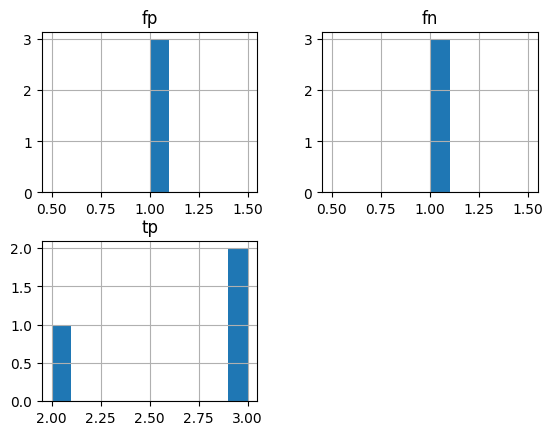

In [58]:
pl = con.hist()

In [59]:
con.reset_index()

farm flavor  threshold  fp  fn  tp
0    a     LF        2.0   1   1   3
1    a     LF        3.0   1   1   3
2    b     LF        2.0   1   1   2

array([[<Axes: title={'center': '(a, LF, 2.0)'}>,
        <Axes: title={'center': '(a, LF, 3.0)'}>],
       [<Axes: title={'center': '(b, LF, 2.0)'}>, <Axes: >]], dtype=object)

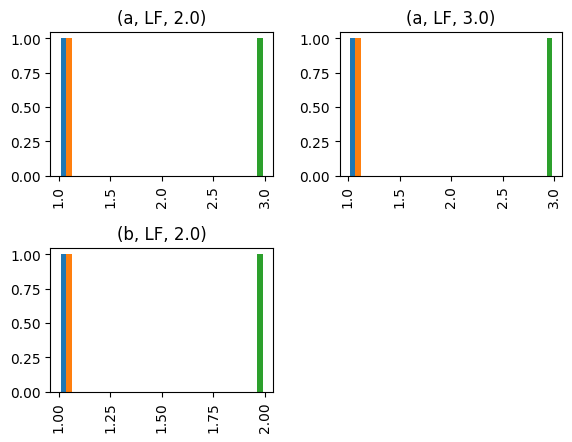

In [60]:
con.hist(by=['farm', 'flavor', 'threshold'])